⊕ [Linguistic Features · spaCy Usage Documentation](https://spacy.io/usage/linguistic-features#pos-tagging)


In [15]:
import spacy
import pandas as pd 

nlp = spacy.load('en_core_web_sm')
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')

def doc_df(doc):
    toks={'index':[], 'governor':[], 'ent':[], 'ent_iob':[],
          'text':[], 'lemma':[], 
          'pos':[], 'tag':[], 'dep':[]}
    for token in doc:
        print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
              token.shape_, token.is_alpha, token.is_stop, '->',
              '[%d.%s]'%(token.head.i, token.head.text))
        # toks['index'].append(token.idx)
        toks['index'].append(token.i)
        toks['text'].append(token.text)
        toks['lemma'].append(token.lemma_)
        toks['pos'].append(token.pos_)
        toks['tag'].append(token.tag_)
        toks['dep'].append(token.dep_)
        
        if token.dep_=='ROOT':
            governor=0
        else:
            governor=token.head.i+1
        toks['governor'].append(governor)
        toks['ent'].append(token.ent_type_)
        # IOB code of named entity tag. `1="I", 2="O", 3="B"`. 0 means no tag is assigned.
        # "B" means the token begins an entity,
        # "I" means it is inside an entity, "O" means it is outside an entity
        toks['ent_iob'].append(token.ent_iob_)

    df = pd.DataFrame(toks) 
    return df

doc_df(doc)

Apple apple PROPN NNP nsubj Xxxxx True False -> [2.looking]
is be VERB VBZ aux xx True True -> [2.looking]
looking look VERB VBG ROOT xxxx True False -> [2.looking]
at at ADP IN prep xx True True -> [2.looking]
buying buy VERB VBG pcomp xxxx True False -> [3.at]
U.K. u.k. PROPN NNP compound X.X. False False -> [6.startup]
startup startup NOUN NN dobj xxxx True False -> [4.buying]
for for ADP IN prep xxx True True -> [4.buying]
$ $ SYM $ quantmod $ False False -> [10.billion]
1 1 NUM CD compound d False False -> [10.billion]
billion billion NUM CD pobj xxxx True False -> [7.for]


,dep,ent,ent_iob,governor,index,lemma,pos,tag,text
0,nsubj,ORG,B,3,0,apple,PROPN,NNP,Apple
1,aux,,O,3,1,be,VERB,VBZ,is
2,ROOT,,O,0,2,look,VERB,VBG,looking
3,prep,,O,3,3,at,ADP,IN,at
4,pcomp,,O,4,4,buy,VERB,VBG,buying
5,compound,GPE,B,7,5,u.k.,PROPN,NNP,U.K.
6,dobj,,O,5,6,startup,NOUN,NN,startup
7,prep,,O,5,7,for,ADP,IN,for
8,quantmod,MONEY,B,11,8,$,SYM,$,$
9,compound,MONEY,I,11,9,1,NUM,CD,1


In [16]:
doc = nlp(u'it is a cat')
doc_df(doc)

it -PRON- PRON PRP nsubj xx True True -> [1.is]
is be VERB VBZ ROOT xx True True -> [1.is]
a a DET DT det x True True -> [3.cat]
cat cat NOUN NN attr xxx True False -> [1.is]


,dep,ent,ent_iob,governor,index,lemma,pos,tag,text
0,nsubj,,O,2,0,-PRON-,PRON,PRP,it
1,ROOT,,O,0,1,be,VERB,VBZ,is
2,det,,O,4,2,a,DET,DT,a
3,attr,,O,2,3,cat,NOUN,NN,cat


In [21]:
from sagas.nlu.spacy_helper import spacy_doc
doc = spacy_doc('hello world', 'en')

verb_domains(be)


,rel,index,text,lemma,children,features
0,nsubj,1,it,-PRON-,[it],"[c_pron, x_prp]"
1,attr,4,cat,cat,"[a, cat]","[c_noun, x_nn]"


attr -> a cat
text: it 	lemma: -PRON-	upos: PRON	xpos: PRP
text: is 	lemma: be	upos: VERB	xpos: VBZ
text: a 	lemma: a	upos: DET	xpos: DT
text: cat 	lemma: cat	upos: NOUN	xpos: NN
it -> nsubj, 2, is
is -> root, 0, _root_
a -> det, 4, cat
cat -> attr, 2, is
('it', 2, 'nsubj')
('is', 0, 'root')
('a', 4, 'det')
('cat', 2, 'attr')


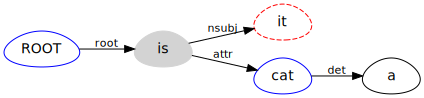

In [8]:
from sagas.nlu.uni_intf import WordIntf, SentenceIntf
from sagas.nlu.corenlp_parser import get_chunks
import sagas
from sagas.tool.misc import print_stem_chunks
from sagas.nlu.uni_viz import EnhancedViz

class RootWordImpl(WordIntf):
    def setup(self, token):
        features = {'index':0, 'text':'ROOT', 'lemma':'root', 'upos':'', 'xpos':'',
                    'feats':[], 'governor':0, 'dependency_relation':''}
        return features
class SpacyWordImpl(WordIntf):
    def setup(self, token):
        if token.dep_=='ROOT':
            governor=0
        else:
            governor=token.head.i+1
        idx=token.i+1  # start from 1
        features = {'index':idx, 'text':token.text, 'lemma':token.lemma_, 
                    'upos':token.pos_, 'xpos':token.tag_,
                    'feats':[], 'governor':governor, 'dependency_relation':token.dep_.lower(),
                    'entity':[token.ent_type_, token.ent_iob_]
                   }
        return features

class SpacySentImpl(SentenceIntf):
    def setup(self, sent):
        words = []
        for word in sent:
            words.append(SpacyWordImpl(word))
        deps = []        
        return words, deps
    
    def build_dependencies(self):
        for word in self.words:
            if word.governor == 0:
                # make a word for the ROOT
                governor = RootWordImpl(None)
            else:
                # id is index in words list + 1
                governor = self.words[word.governor-1]
            self.dependencies.append((governor, word.dependency_relation, word))

class SpacyParserImpl(object):
    def __init__(self, lang):
        self.lang = lang

    def __call__(self, sents):
        from sagas.nlu.spacy_helper import spacy_doc
        doc = spacy_doc(sents, self.lang)
        return SpacySentImpl(doc)

p=SpacyParserImpl('en')
doc=p('it is a cat')
# print(doc.words)
doc.build_dependencies()
# print(doc.dependencies)
rs = get_chunks(doc)
# print(rs)
for r in rs:
    df = sagas.to_df(r['domains'], ['rel', 'index', 'text', 'lemma', 'children', 'features'])
    print('%s(%s)' % (r['type'], r['lemma']))
    # sagas.print_df(df)
    display(df)
    print_stem_chunks(r)
    
cv = EnhancedViz(shape='egg', size='8,5', fontsize=20)
cv.analyse_doc(doc, None)

## Noun chunks
Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over Doc.noun_chunks

In [4]:
doc = nlp(u"Autonomous cars shift insurance liability toward manufacturers")

toks={'text':[], 'root_text':[], 'root_dep':[], 'head':[]}
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_,
            chunk.root.head.text)
    toks['text'].append(chunk.text)
    toks['root_text'].append(chunk.root.text)
    toks['root_dep'].append(chunk.root.dep_)
    toks['head'].append(chunk.root.head.text)
df = pd.DataFrame(toks) 
df    

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


,head,root_dep,root_text,text
0,shift,nsubj,cars,Autonomous cars
1,shift,dobj,liability,insurance liability
2,toward,pobj,manufacturers,manufacturers


## Navigating the parse tree
spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

In [2]:
doc = nlp(u"Autonomous cars shift insurance liability toward manufacturers")
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability, toward]
insurance compound liability NOUN []
liability dobj shift VERB [insurance]
toward prep shift VERB [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [16]:
import spacy
from spacy.symbols import nsubj, VERB

nlp = spacy.load("en_core_web_sm")
doc = nlp(u"Autonomous cars shift insurance liability toward manufacturers")

# Finding a verb with a subject from below — good
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


In [12]:
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(u"Autonomous cars shift insurance liability toward manufacturers")
# Since this is an interactive Jupyter environment, we can use displacy.render here
# displacy.render(doc, style='dep')

In [13]:
import spacy
from spacy import displacy

text = """But Google is starting from behind. The company made a late push
into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa
software, which runs on its Echo and Dot devices, have clear leads in
consumer adoption."""

nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
# displacy.serve(doc, style="ent")

In [4]:
import resources_pb2 as res
import protobuf_utils

input_file='./data/langs/jpn_eng_spacy.data'
load_langs = res.RsLangs()
protobuf_utils.read_proto(load_langs, input_file)
print(len(load_langs.langs))

36763


In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [5]:
from spacy.tokens import Doc
# lang=load_langs.langs[188]
for lang in load_langs.langs[2000:2120]:
    doc = Doc(nlp.vocab).from_bytes(lang.store)
    print(lang.entries[0], lang.verbs, lang.verbLemmas)

Choose a password that is easy to remember but difficult to guess. ['is'] ['be']
Choose any dress you like. ['like'] ['like']
Choose any one from among these. [] []
Choose friends you can rely on. ['rely'] ['rely']
Choose one person. [] []
Choose one. [] []
Choose the one you like. ['like'] ['like']
Choose whichever you like. ['like'] ['like']
Choose whichever you want. ['want'] ['want']
Christianity and Islam are two different religions. ['are'] ['be']
Christmas Day is December 25th. ['is'] ['be']
Christmas comes but once a year. ['comes'] ['come']
Christmas fell on Saturday that year. ['fell'] ['fall']
Christmas is December 25th. ['is'] ['be']
Christmas is coming soon. ['coming'] ['come']
Christmas is coming. ['coming'] ['come']
Christmas is fast approaching. ['is'] ['be']
Christmas is just around the corner. ['is'] ['be']
Christmas is just two weeks from now. ['is'] ['be']
Christmas is near at hand, isn't it? ['is', 'is'] ['be', 'be']
Christmas is only two weeks off. ['is'] ['be']
C

In [6]:
import numpy as np 
englist=[]
for lang in load_langs.langs:
    englist.append(lang.entries[0])
x=np.array(englist) 
rs=np.unique(x)
print(len(rs))

36763


In [23]:
print(rs[0])
doc=nlp(str(rs[0]))
doc_df(doc)

"A stitch in time saves nine" is a proverb.
" " PUNCT `` punct " False False
A a DET DT det X True False
stitch stitch NOUN NN nsubj xxxx True False
in in ADP IN prep xx True True
time time NOUN NN pobj xxxx True False
saves save VERB VBZ csubj xxxx True False
nine nine NUM CD dobj xxxx True True
" " PUNCT `` punct " False False
is be VERB VBZ ROOT xx True True
a a DET DT det x True True
proverb proverb NOUN NN attr xxxx True False
. . PUNCT . punct . False False


,dep,lemma,pos,tag,text
0,punct,"""",PUNCT,``,""""
1,det,a,DET,DT,A
2,nsubj,stitch,NOUN,NN,stitch
3,prep,in,ADP,IN,in
4,pobj,time,NOUN,NN,time
5,csubj,save,VERB,VBZ,saves
6,dobj,nine,NUM,CD,nine
7,punct,"""",PUNCT,``,""""
8,ROOT,be,VERB,VBZ,is
9,det,a,DET,DT,a


In [27]:
import random
print(len(rs))
sampling = random.choices(rs, k=5)
print("sampling with choices function ", sampling)

36763
sampling with choices function  ['I look forward to my birthday.', "Don't throw in the towel.", 'There are a lot of trees around the pond.', "I'm proud to be a part of this project.", 'He is still very much alive.']


In [13]:
import numpy
array = numpy.array([[11 ,22, 33], [44, 55, 66], [77, 88, 99]]) 
print("Printing 2D Array")
print(array)
print("Choose random row from 2D array")
randomRow = numpy.random.randint(3, size=2)
print(randomRow)
print(array[randomRow,:])

Printing 2D Array
[[11 22 33]
 [44 55 66]
 [77 88 99]]
Choose random row from 2D array
[0 0]
[[11 22 33]
 [11 22 33]]


In [9]:
?numpy.random.randint